In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fundus-image-dataset-for-vessel-segmentation/Quality Assessment.xlsx
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Ground truth/58_D.png
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Ground truth/111_G.png
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Ground truth/171_N.png
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Ground truth/170_N.png
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Ground truth/1_A.png
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Ground truth/91_D.png
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Ground truth/105_G.png
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Ground truth/80_D.png
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Ground truth/193_N.png
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Ground truth/94_D.png
/kaggle/input/fundus-image-dataset-for-vessel-segment

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

def define_discriminator(image_shape):

	# weight initialization
	init = RandomNormal(stddev=0.02)

	# source image input
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=image_shape)  #Image we want to generate after training.

	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])

	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt.
    #with a small learning rate and 0.5 beta.
    #The loss for the discriminator is weighted by 50% for each model update.

	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# disc_model = define_discriminator((256,256,3))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)

def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# standalone generator model - U-net
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

gen_model = define_generator((256,256,3))
plot_model(gen_model, to_file='gen_model.png', show_shapes=True)


# combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# making weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but
                                                #standalone descriminator will be trainable.

	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)

    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'],
               optimizer=opt, loss_weights=[1,100])
	return model

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    n_patch = d_model.output_shape[1]
    trainA, trainB = dataset
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs

    best_g_loss = float('inf')  # initialize best generator loss

    for i in range(n_steps):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

        # ✅ Save model if it's the best so far
        if g_loss < best_g_loss:
            best_g_loss = g_loss
            g_model.save('/kaggle/working/pix2pix_best_generator.h5')
            print(f"✅ Best generator saved at step {i+1} with g_loss {g_loss:.3f}")

        # Periodically plot and save
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)


Loaded: (200, 256, 256, 3) (200, 256, 256, 3)


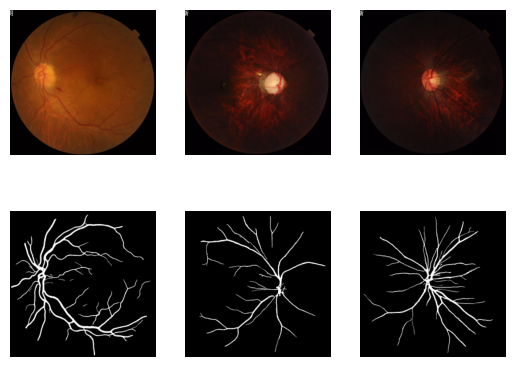

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
>1, d1[0.423] d2[0.422] g[98.385]
✅ Best generator saved at step 1 with g_loss 98.385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>2, d1[0.422] d2[0.412] g[95.475]
✅ Best generator saved at step 2 with g_loss 95.475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>3, d1[0.415] d2[0.412] g[93.443]
✅ Best generator saved at step 3 with g_loss 93.443
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>4, d1[0.414] d2[0.412] g[91.810]
✅ Best generator saved at step 4 with g_loss 91.810
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>5, d1[0.413] d2[0.412] g[90.224]
✅ Best generator saved at step 5 with g_loss 90.224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>6, d1[0.413] d2[0.414] g[88.992]
✅ Best generator saved at step 6 with g_loss 88.992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>7, d1[0.414] d2[0.413] g[87.667]
✅ Best generator saved at step 7 with g_loss 87.667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>8, d1[0.413] d2[0.413] g[86.375]
✅ Best generator saved at step 8 with g_loss 86.375
1/1 ━━━━━━

In [ ]:
import os
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np
from PIL import Image
import numpy as np
import os
from PIL import Image
import numpy as np
import os

def load_fundus_dataset(original_dir, gt_dir, size=(256, 256)):
    src_list, tar_list = [], []
    for filename in sorted(os.listdir(original_dir)):
        if not filename.lower().endswith(('.jpg', '.png')):
            continue
        img_path = os.path.join(original_dir, filename)
        mask_path = os.path.join(gt_dir, filename)

        if not os.path.exists(mask_path):
            print(f"[!] Missing mask for: {filename}")
            continue

        retina = Image.open(img_path).convert('RGB').resize(size)
        # mask = Image.open(mask_path).convert('L').resize(size)  # Grayscale
        mask = Image.open(mask_path).convert('RGB').resize(size)
        tar_list.append(np.array(mask))


        src_list.append(np.array(retina))
        # tar_list.append(np.expand_dims(np.array(mask), axis=-1))

    return np.array(src_list), np.array(tar_list)

original_path = '/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Original/'
mask_path     = '/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Ground truth/'

src_images, tar_images = load_fundus_dataset(original_path, mask_path)
print('Loaded:', src_images.shape, tar_images.shape)


n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

#######################################

# define input shape based on the loaded dataset
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

#Define data
# load and prepare training images
data = [src_images, tar_images]

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

from datetime import datetime
start1 = datetime.now()

train(d_model, g_model, gan_model, dataset, n_epochs=40, n_batch=1)

stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

In [11]:
g_model.save('/kaggle/working/pix2pix_generator_final.h5')


In [14]:
model = g_model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


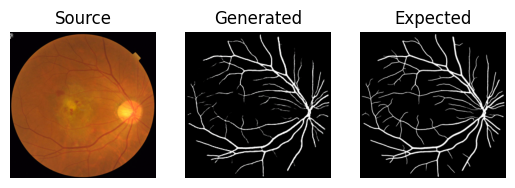

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Saved: test_results/test_result_0.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Saved: test_results/test_result_1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Saved: test_results/test_result_2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Saved: test_results/test_result_3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Saved: test_results/test_result_4.png


In [ ]:
from keras.models import load_model
from numpy.random import randint
import os
# model = load_model()

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()



[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)




# Define a function to save the images
def save_images(src_img, gen_img, tar_img, folder_path, filename):
    images = vstack((src_img, gen_img, tar_img))
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    for i in range(len(images)):
        pyplot.subplot(1, 3, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(images[i])
        pyplot.title(titles[i])
    save_path = f'{folder_path}/{filename}'
    pyplot.savefig(save_path)
    print(f'Saved: {save_path}')
    pyplot.close()






# Define a folder for saving test results
test_results_folder = 'test_results'
os.makedirs(test_results_folder, exist_ok=True)

# Generate and display results for multiple test images
num_test_images = 5  # Set the number of test images you want to generate
for i in range(num_test_images):
    # Select random example
    ix = randint(0, len(X1), 1)
    src_image, tar_image = X1[ix], X2[ix]
    # Generate image from source
    gen_image = model.predict(src_image)
    # Save the results
    save_images(src_image, gen_image, tar_image, test_results_folder, f'test_result_{i}.png')

In [17]:
import os
print(os.listdir('/kaggle/working/'))


['.virtual_documents', 'model_008000.h5', 'plot_004000.png', 'model_006000.h5', 'plot_008000.png', 'plot_006000.png', 'plot_002000.png', 'model_002000.h5', 'model_004000.h5', 'gen_model.png', 'pix2pix_best_generator.h5', 'test_results', 'pix2pix_generator_final.h5']


In [18]:
import tarfile

# Compress the model to a .tar.gz file
with tarfile.open('/kaggle/working/pix2pix_model.tar.gz', 'w:gz') as tar:
    tar.add('/kaggle/working/pix2pix_generator_final.h5', arcname='pix2pix_generator_final.h5')


In [20]:
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

# Load test images and their corresponding masks
def load_test_images(original_dir, mask_dir, size=(256, 256)):
    src_list, tar_list = [], []
    for filename in sorted(os.listdir(original_dir)):
        if not filename.lower().endswith(('.jpg', '.png')):
            continue
        img_path = os.path.join(original_dir, filename)
        mask_path = os.path.join(mask_dir, filename)  # Assuming same filename for GT

        if not os.path.exists(mask_path):
            print(f"[!] Missing mask for: {filename}")
            continue

        # Load images and resize
        retina = load_img(img_path, target_size=size)
        mask = load_img(mask_path, target_size=size)

        src_list.append(np.array(retina))
        tar_list.append(np.array(mask))

    return np.array(src_list), np.array(tar_list)

# Update paths based on Kaggle input folder
original_path = '/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Original/'
mask_path = '/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Ground truth/'

test_src_images, test_tar_images = load_test_images(original_path, mask_path)
print('Loaded test data:', test_src_images.shape, test_tar_images.shape)
# Preprocessing step to normalize images to [-1, 1]
def preprocess_data(data):
    X1, X2 = data[0], data[1]
    X1 = (X1 - 127.5) / 127.5  # Normalize from [0, 255] to [-1, 1]
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

# Preprocess the test dataset
test_dataset = preprocess_data([test_src_images, test_tar_images])


Loaded test data: (200, 256, 256, 3) (200, 256, 256, 3)


In [23]:
from skimage.metrics import mean_squared_error, structural_similarity, peak_signal_noise_ratio

def evaluate_model(model, test_dataset):
    [X1, X2] = test_dataset
    num_samples = len(X1)
    mse_total = 0.0
    ssim_total = 0.0
    psnr_total = 0.0

    for i in range(num_samples):
        src_image, tar_image = X1[i], X2[i]
        gen_image = model.predict(np.expand_dims(src_image, axis=0))

        # Calculate metrics
        mse = mean_squared_error(tar_image, gen_image[0])

        # Set the window size for SSIM to 3 (or smaller) to avoid the error
        # Specify data_range for floating point images
        ssim = structural_similarity(tar_image, gen_image[0], multichannel=True, win_size=3, data_range=tar_image.max() - tar_image.min())
        
        psnr = peak_signal_noise_ratio(tar_image, gen_image[0])

        mse_total += mse
        ssim_total += ssim
        psnr_total += psnr

    mse_avg = mse_total / num_samples
    ssim_avg = ssim_total / num_samples
    psnr_avg = psnr_total / num_samples

    print(f'Mean Squared Error (MSE): {mse_avg}')
    print(f'Structural Similarity Index (SSIM): {ssim_avg}')
    print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr_avg}')

# Evaluate the model
evaluate_model(model, test_dataset)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/tmp/ipykernel_37/3721676741.py:21: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(tar_image, gen_image[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━